In [4]:
import os
import sys
import argparse
from os.path import dirname, realpath


In [5]:
sys.path.append("./src/")
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [6]:
%run load_PheOnly.py

In [194]:
wts01 = np.where(gold1 == 1, 1/(np.mean(gold1)* np.mean(.064)* (1-mp1) **1), 1/ mp1**1)
wts02 = np.where(gold2 == 1, 1/(np.mean(gold2)* np.mean(.064)* (1-mp2) **1), 2/ mp2**1)
wts03 = np.where(gold3 == 1, 1/(np.mean(gold3)*np.mean(.064) *(1-mp3) **1), 3/ mp3**1)
wts04 = np.where(gold4 == 1, 1/(np.mean(gold4)*np.mean(.064)* (1-mp4) **1), 4/ mp4**1)

In [91]:
np.mean(gold0)

0.018841341999474022

In [267]:
wts01 = np.where(gold1 == 1, 1/(np.mean(gold1)* (1-mp1) ), 1/ mp1)
wts02 = np.where(gold2 == 1, 1/(np.mean(gold2)* (1-mp2) ), 2/ mp2)
wts03 = np.where(gold3 == 1, 1/(np.mean(gold3)* (1-mp3) ), 3/ mp3)
wts04 = np.where(gold4 == 1, 1/(np.mean(gold4)* (1-mp4) ), 4/ mp4)


In [268]:
wts1234 = np.concatenate((wts01,wts02, wts03, wts04))
y1234 = np.concatenate((gold1,gold2, gold3, gold4))
lo1234 = logit( np.concatenate((mp1,mp2, mp3, mp4)) )
tlo1234 = logit( np.concatenate((tp1,tp2, tp3, tp4)) )
ti = np.concatenate((np.ones(len(mp1)), 2*np.ones(len(mp2)), 3*np.ones(len(mp3)), 4*np.ones(len(mp4))))
tti = np.concatenate((np.ones(len(tp1)), 2*np.ones(len(tp2)), 3*np.ones(len(tp3)), 4*np.ones(len(tp4))))

In [269]:
def weighted_temp2_scaling (logits, y, wts):
    def temperature_obj(t):
        temp_logits =   (logits + t[1]) /  t [0]  
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize (temperature_obj,x0 = [.1,.1])
    return res.x

def temp_pred2 (alpha,  test_logit):    
    logi =  (test_logit + alpha[1])/ alpha[0]     
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [270]:
alpha_0_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)


In [271]:
pc = temp_pred2(alpha_0_1234, lo1234 )

(array([3.7221e+04, 6.7460e+03, 3.2700e+03, 2.0660e+03, 1.4610e+03,
        1.0890e+03, 7.3000e+02, 4.3500e+02, 1.8900e+02, 2.7000e+01]),
 array([0.00088741, 0.08359408, 0.16630075, 0.24900742, 0.33171409,
        0.41442076, 0.49712743, 0.5798341 , 0.66254077, 0.74524744,
        0.82795411]),
 <BarContainer object of 10 artists>)

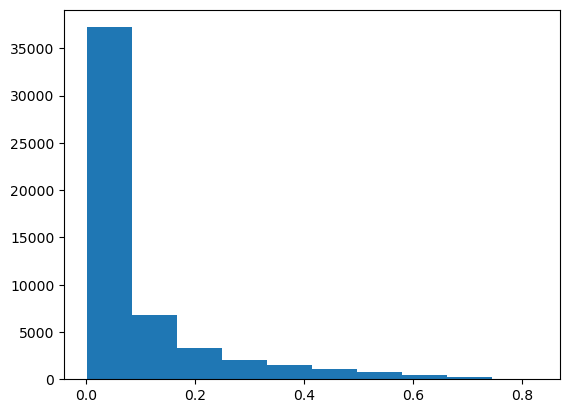

In [272]:
plt.hist(pc)

In [273]:
wp1 = ( pc [ti==1])
wp2 = ( pc [ti==2]) 
wp3 = ( pc [ti==3]) 
wp4 =  (pc [ti==4])
np1 =  ((1-pc) [ti==1])
np2 =  ((1-pc) [ti==2])
np3 =  ((1-pc) [ti==3])
np4 =  ((1-pc) [ti==4])

In [274]:
wts1 = np.where(gold1 == 1, 1/( np1 *np.mean(gold1)), 1/wp1)
wts2 = np.where(gold2 == 1, 1/( np2 *np.mean(gold2)), 1/wp2)
wts3 = np.where(gold3 == 1, 1/( np3 *np.mean(gold3)), 1/wp3 )
wts4 = np.where(gold4 == 1, 1/( np4 *np.mean(gold4)), 1/wp4 )

In [275]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1* t[5]  +  t[1])  
        logi_2 = (l2 * t[6]  +  t[2])  
        logi_3 = (l3 * t[7] +  t[3])  
        logi_4 = (l4 * t[8] +  t[4])  
        
        p1  = expit (t[0] * logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] * logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1, .1  ] )    
    return  r

In [276]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [277]:
tt['message']

'Optimization terminated successfully.'

In [278]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit * j2    + j1    )  
    proba = expit (  logi * tt.x[0]  )  
    return proba

In [314]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

y1, p1 = calibration_curve(M_test1['golds'], cal_1 , n_bins = 200)
y2, p2 = calibration_curve(M_test2['golds'], cal_2 , n_bins = 250)
y3, p3 =calibration_curve(M_test3['golds'], cal_3 , n_bins = 250)
y4, p4 = calibration_curve(M_test4['golds'], cal_4 , n_bins = 250)

In [315]:
p4_ = p4 [y4>0]
y4_ = y4 [y4>0]
p3_ = p3 [y3>0]
y3_ = y3 [y3>0]
p2_ = p2 [y2>0]
y2_ = y2 [y2>0]
p1_ = p1 [y1>0]
y1_ = y1 [y1>0]

In [323]:
#plot1.savefig(os.path.join(fig_folder, 'cal1.png'), bbox_inches='tight')
fig_folder = 'C:/Users/VHANYNHeT/Desktop/PI04/Figures'

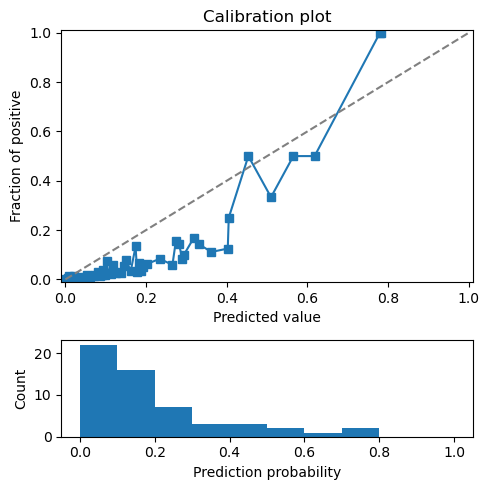

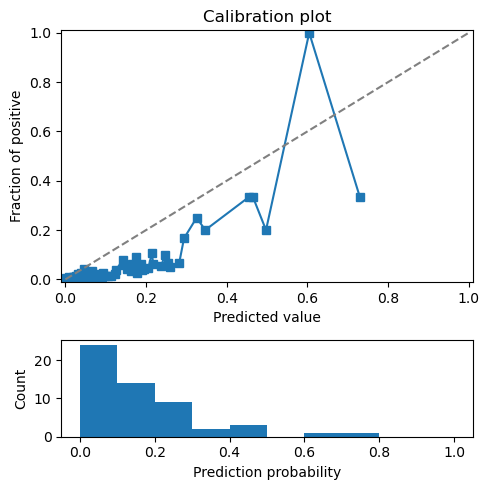

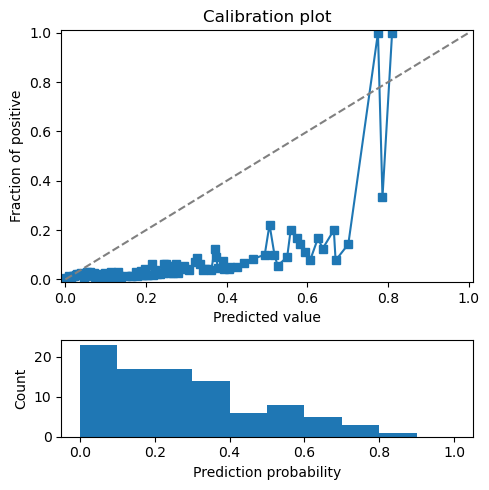

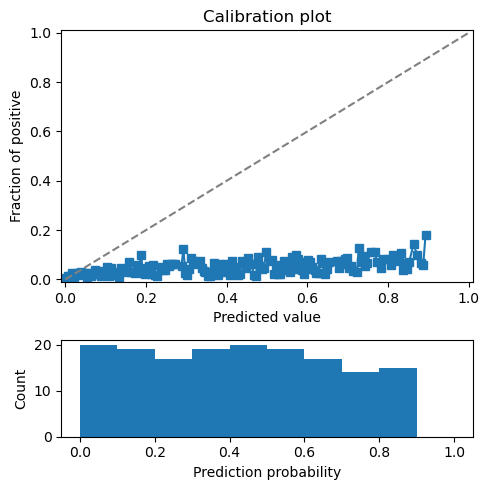

In [317]:
plot4 = plotter(p4_, y4_)
plot3 = plotter(p3_, y3_)
plot2 = plotter(p2_, y2_)
plot1 = plotter(p1_, y1_)

In [324]:
plot1.savefig(os.path.join(fig_folder, 'phecal1.png'), bbox_inches='tight')
plot2.savefig(os.path.join(fig_folder, 'phecal2.png'), bbox_inches='tight')
plot3.savefig(os.path.join(fig_folder, 'phecal3.png'), bbox_inches='tight')
plot4.savefig(os.path.join(fig_folder, 'phecal4.png'), bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [285]:
import sklearn
from sklearn.metrics import confusion_matrix

In [318]:
[sklearn.metrics.roc_auc_score(tgold4,  tp4 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold3,  tp3 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold2,  tp2 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold1,  tp1 , average = 'samples')]


[0.7072423069302404,
 0.6854529873329583,
 0.6455460267776995,
 0.6480031999535442]

In [319]:
( confusion_matrix (tgold1,  cal_1>.5) )

array([[12803,  2716],
       [  358,   148]], dtype=int64)

In [320]:
( confusion_matrix (tgold2,  cal_2>.5) )

array([[13401,   454],
       [  180,    19]], dtype=int64)

In [321]:
( confusion_matrix (tgold3,  cal_3>.5) )

array([[12340,   107],
       [  130,     2]], dtype=int64)

In [322]:
( confusion_matrix (tgold4,  cal_4>.5) )

array([[10551,   161],
       [   93,     5]], dtype=int64)